In [1]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.plotting import simple_plot

import pandas as pd
import numpy as np
from numpy.random import default_rng
import cvxpy as cp
import networkx as nx
import mosek
import custom_networks

from solution_files_manager import SolutionFilesManager
from opt_utils import *
from opf_utils import *

In [2]:
import os
folder = os.path.abspath(os.getcwd())

## Data processing

In [3]:
case = "case39"
net = custom_networks.get_case(case)
n = len(net.bus)

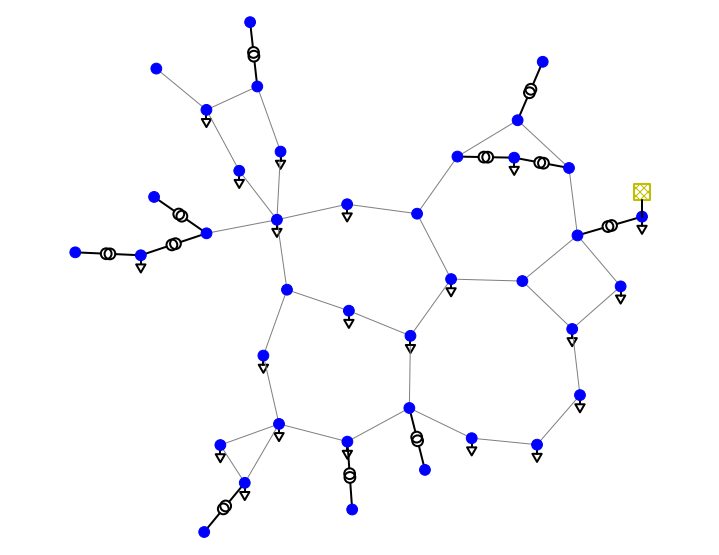

<AxesSubplot:>

In [4]:
simple_plot(net, plot_loads=True, plot_sgens=True)

#### Generators57

In [5]:
gen_df_list = []
gen_class_list = ["ext_grid", "gen", "sgen"]  # the 3 types of generators
data_col_list = ["bus", "max_p_mw", "min_p_mw", "max_q_mvar", "min_q_mvar"]

for gen_class in gen_class_list:
    if not net[gen_class].empty:
        # get a table of cost coefficients only for the current type of generators
        gen_class_poly_cost = net.poly_cost.loc[net.poly_cost.et == gen_class].set_index("element")
        # get a table of cost coefficients and power bounds only for the current type of generators
        gen_class_df = net[gen_class][data_col_list].join(gen_class_poly_cost)
        gen_df_list.append(gen_class_df)

# combine tables for all types of generators
gen_df = pd.concat(gen_df_list).reset_index()
n_gen = len(gen_df)
gens = gen_df["bus"].to_numpy()

In [6]:
gen_df

,index,bus,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,0,30,646.0,0.0,300.0,-100.0,ext_grid,0.2,0.3,0.01,0.0,0.0,0.0
1,0,29,1040.0,0.0,400.0,140.0,gen,0.2,0.3,0.01,0.0,0.0,0.0
2,1,31,725.0,0.0,300.0,150.0,gen,0.2,0.3,0.01,0.0,0.0,0.0
3,2,32,652.0,0.0,250.0,0.0,gen,0.2,0.3,0.01,0.0,0.0,0.0
4,3,33,508.0,0.0,167.0,0.0,gen,0.2,0.3,0.01,0.0,0.0,0.0
5,4,34,687.0,0.0,300.0,-100.0,gen,0.2,0.3,0.01,0.0,0.0,0.0
6,5,35,580.0,0.0,240.0,0.0,gen,0.2,0.3,0.01,0.0,0.0,0.0
7,6,36,564.0,0.0,250.0,0.0,gen,0.2,0.3,0.01,0.0,0.0,0.0
8,7,37,865.0,0.0,300.0,-150.0,gen,0.2,0.3,0.01,0.0,0.0,0.0
9,8,38,1100.0,0.0,300.0,-100.0,gen,0.2,0.3,0.01,0.0,0.0,0.0


#### Bus loads

In [7]:
load_df = net.bus.join(net.load[["bus", "p_mw", "q_mvar"]].set_index("bus")).fillna(0)[["p_mw", "q_mvar"]]

In [8]:
load_df

,p_mw,q_mvar
0,97.60,44.2
1,0.00,0.0
2,322.00,2.4
3,500.00,184.0
4,0.00,0.0
5,0.00,0.0
6,233.80,84.0
7,522.00,176.6
8,6.50,-66.6
9,0.00,0.0


#### Admittance matrices

In [9]:
# compute line susceptance in p.u.
net.line['s_pu'] = net.line['c_nf_per_km'] * net.line["length_km"] * (2 * np.pi * net.f_hz) * \
    ((net.bus.loc[net.line.from_bus.values, "vn_kv"].values) ** 2) / net.sn_mva / net.line['parallel'] / 1e9

In [10]:
# obtain a NetworkX Graph from the network, with each edge containing p.u. impedance data
graph = pp.topology.create_nxgraph(net, multi=False, calc_branch_impedances=True, branch_impedance_unit="pu")

In [11]:
G_val, B_val, Y_val = compute_admittance_mat(net, graph)

## Variables

In [12]:
# X = VV*
X = cp.Variable((n,n), hermitian=True)
# active power generated
p_g = cp.Variable((n_gen, 1))
# reactive power generated
q_g = cp.Variable((n_gen, 1))

## Parameters

In [13]:
p_d_val = load_df[["p_mw"]].to_numpy() / net.sn_mva
q_d_val = load_df[["q_mvar"]].to_numpy() / net.sn_mva

In [14]:
# loads
p_d = cp.Parameter((n,1), nonneg=True, value=p_d_val)
q_d = cp.Parameter((n,1), value=q_d_val)

# admittance matrices
G = cp.Parameter((n,n), symmetric=True, value=G_val)
B = cp.Parameter((n,n), symmetric=True, value=B_val)
Y = cp.Parameter((n,n), complex=True, value=Y_val)

# squares of voltage bounds
V_min_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["min_vm_pu"].to_numpy()))
V_max_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["max_vm_pu"].to_numpy()))

# bounds for generated power
# TODO: check whether these are for net injections (supply - demand) or for generated power (supply)
p_min = cp.Parameter((n_gen,1), value=gen_df[["min_p_mw"]].to_numpy() / net.sn_mva)
p_max = cp.Parameter((n_gen,1), value=gen_df[["max_p_mw"]].to_numpy() / net.sn_mva)
q_min = cp.Parameter((n_gen,1), value=gen_df[["min_q_mvar"]].to_numpy() / net.sn_mva)
q_max = cp.Parameter((n_gen,1), value=gen_df[["max_q_mvar"]].to_numpy() / net.sn_mva)

In [15]:
# vectors of cost coefficients: c_[p or q]_[power]
# costs are only on generators

c_p_2 = cp.Parameter((n_gen), value=gen_df["cp2_eur_per_mw2"].to_numpy() * (net.sn_mva**2), nonneg=True)
c_p_1 = cp.Parameter((n_gen), value=gen_df["cp1_eur_per_mw"].to_numpy() * net.sn_mva, nonneg=True)
c_p_0 = cp.Parameter((n_gen), value=gen_df["cp0_eur"].to_numpy(), nonneg=True)

c_q_2 = cp.Parameter((n_gen), value=gen_df["cq2_eur_per_mvar2"].to_numpy() * (net.sn_mva**2), nonneg=True)
c_q_1 = cp.Parameter((n_gen), value=gen_df["cq1_eur_per_mvar"].to_numpy() * net.sn_mva, nonneg=True)
c_q_0 = cp.Parameter((n_gen), value=gen_df["cq0_eur"].to_numpy(), nonneg=True)

In [16]:
Phis = []
Psis = []
for i in range(n):
    J_i = np.zeros((n,n))
    J_i[i][i] = 1
    Y_i = J_i @ Y_val
    Phi_i = 1 / 2 * (Y_i.conj().T + Y_i)
    Phis.append(Phi_i)
    Psi_i = 1 / 2j * (Y_i.conj().T - Y_i)
    Psis.append(Psi_i)

In [17]:
# SOCP constraint
# constraints = [ cp.quad_over_lin(cp.norm(X[i][j]), cp.real(X[i][i])) <= cp.real(X[j][j]) for i,j in graph.edges]

### SDP (non-QCQP)

In [18]:
constraints = [X >> 0]

for i in range(n):
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    constraints += [
        cp.sum([p_g[k] for k in gen_list]) - p_d[i] == G[i][i] * X[i][i] +
        cp.sum([G[i][j] * cp.real(X[i][j]) + B[i][j] * cp.imag(X[i][j]) for j in graph.neighbors(i)])
    ]
    constraints += [
        cp.sum([q_g[k] for k in gen_list]) - q_d[i] == -B[i][i] * X[i][i] +
        cp.sum([-B[i][j] * cp.real(X[i][j]) + G[i][j] * cp.imag(X[i][j]) for j in graph.neighbors(i)])
    ]

constraints += [
    cp.real(cp.diag(X)) >= V_min_sq,
    cp.real(cp.diag(X)) <= V_max_sq
]

constraints += [
    p_g >= p_min,
    p_g <= p_max,
    q_g >= q_min,
    q_g <= q_max
]

In [19]:
p_cost = c_p_2 @ cp.square(p_g) + c_p_1 @ p_g + cp.sum(c_p_0)
q_cost = c_q_2 @ cp.square(q_g) + c_q_1 @ q_g + cp.sum(c_q_0)

In [20]:
# power generation cost
prob = cp.Problem(cp.Minimize(p_cost + q_cost), constraints)

# heuristic penalization
# prob = cp.Problem(cp.Minimize(p_cost + q_cost + 0.5 * cp.sum(q_g)), constraints)
# prob = cp.Problem(cp.Minimize(p_cost + q_cost - cp.real(cp.sum(X))), constraints)

In [21]:
# prob.solve(solver=cp.SCS, verbose=True)  # eps=1e-6
# prob.solve(solver=cp.CVXOPT, verbose=True)
# prob.solve(solver=cp.MOSEK, mosek_params={mosek.iparam.intpnt_solve_form : mosek.solveform.dual}, verbose=False)

In [22]:
# # print original cost (if using penalization)
# print(p_cost.value + q_cost.value)

### Build sparsity graph

In [23]:
sparsity_graph = nx.Graph()
graph_nodes_list = sorted(graph.nodes())
# the sparsity graph of complex variables is exactly the power network
sparsity_graph.add_nodes_from(graph_nodes_list)
sparsity_graph.add_edges_from(graph.edges())

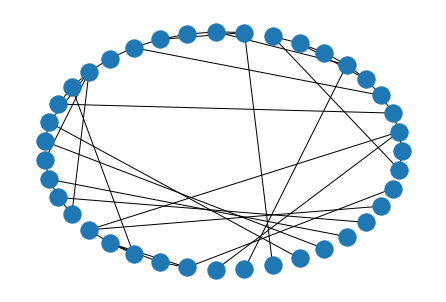

In [24]:
nx.draw(sparsity_graph, nx.circular_layout(sparsity_graph))

## TODO: edge elimination

In [25]:
# edge_elimination_list = list(sparsity_graph.edges)
# sparsity_graph.remove_edges_from(edge_elimination_list)

In [26]:
# for e in edge_elimination_list:
#     sparsity_graph.add_node((e,1))
#     sparsity_graph.add_node((e,2))
#
# sparsity_graph.add_node("one")
#
# for e in edge_elimination_list:
#     sparsity_graph.add_edge((e,1), "one")
#     sparsity_graph.add_edge((e,2), "one")
#     sparsity_graph.add_edge(e[0], "one")
#     sparsity_graph.add_edge(e[1], "one")

In [27]:
# nx.set_edge_attributes(sparsity_graph, 0, "weight")
# n_sparse = sparsity_graph.number_of_nodes()
#
# for i in range(n):
#     Phi_i = Phis[i].value
#     graph_phi_i = sparsity_graph.copy()
#     graph_phi_i.add_edge(i, i, weight=Phi_i[i][i])
#
#     Psi_i = Psis[i].value
#     graph_psi_i = sparsity_graph.copy()
#     graph_psi_i.add_edge(i, i, weight=Psi_i[i][i])
#
#     for j in graph.neighbors(i):  # quadratic terms only appear for adjacent buses
#         if (i,j) in edge_elimination_list:
#             # replace variables in the constraints of bus i
#             graph_phi_i.edges[(((i, j), 1), ((i, j), 1))]["weight"] = Phi_i[i][j]
#             graph_phi_i.edges[(((i, j), 2), ((i, j), 2))]["weight"] = -Phi_i[i][j]
#
#             # TODO: graph_psi_i
#
#             # impose linear constraints on the new variables
#             linear_constraint_mat = np.zeros(n_sparse)
#             # TODO
#
#
#         else:
#             # don't replace variables in the constraints of bus i
#             graph_phi_i.edges[(i, j)]["weight"] = G_val[i][j]
#             graph_phi_i.edges[(n + i, n + j)]["weight"] = G_val[i][j]
#             graph_phi_i.edges[(i, n + j)]["weight"] = -B_val[i][j]
#             graph_phi_i.edges[(n + i, j)]["weight"] = B_val[i][j]
#
#             # TODO

### Construct enriched supergraph

In [28]:
G_bar = build_enriched_supergraph(sparsity_graph)

Treewidth: 3


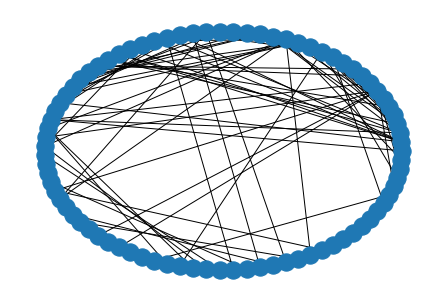

In [29]:
nx.draw(G_bar, nx.circular_layout(G_bar))

## SDP (QCQP)

In [30]:
constraints = [X >> 0]

for i in range(n):
    # TODO: multiple generators at one bus
    if i in gens:
        i_gen_idx = list(gens).index(i)
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) + p_d[i] <= p_max[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) + p_d[i] >= p_min[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) + q_d[i] <= q_max[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) + q_d[i] >= q_min[i_gen_idx] ]
    else:
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) == -p_d[i] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) == -q_d[i] ]

constraints += [
    cp.real(cp.diag(X)) >= V_min_sq,
    cp.real(cp.diag(X)) <= V_max_sq
]

In [31]:
# the power generation costs are not dpp but can be modified
p_cost = cp.sum([ c_p_2[i] * cp.square((cp.real(cp.trace(Phis[gens[i]] @ X)) + p_d[gens[i]])) + c_p_1[i] * (cp.real(cp.trace(Phis[gens[i]] @ X)) + p_d[gens[i]]) for i in range(n_gen) ]) + cp.sum(c_p_0)
q_cost = cp.sum([ c_q_2[i] * cp.square((cp.real(cp.trace(Psis[gens[i]] @ X)) + p_d[gens[i]])) + c_q_1[i] * (cp.real(cp.trace(Psis[gens[i]] @ X)) + q_d[gens[i]]) for i in range(n_gen) ]) + cp.sum(c_q_0)

loss_cost = cp.sum([ cp.sum([ G[i][j] * cp.real(X[i][i] + X[j][j] - X[i][j] - X[j][i]) for j in range(i)]) for i in range(n)])

In [32]:
# power generation cost
prob = cp.Problem(cp.Minimize(p_cost + q_cost), constraints)

# line loss
# prob = cp.Problem(cp.Minimize(loss_cost), constraints)

In [33]:
# prob.solve(solver=cp.SCS, verbose=False)  # eps=1e-6
# prob.solve(solver=cp.CVXOPT, verbose=True)
# prob.solve(solver=cp.MOSEK, mosek_params={mosek.iparam.intpnt_solve_form : mosek.solveform.dual}, verbose=False)
prob.solve()

/home/ivanightingale/miniconda3/envs/convex/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


41867.77896993481

In [34]:
print_rank_data(X.value)

The eigenvalues are
[-1.19894519e-09 -1.19059583e-09 -1.16078275e-09 -1.15901161e-09
 -1.15064318e-09 -1.14249872e-09 -1.12003509e-09 -1.08141416e-09
 -1.05608585e-09 -1.05140104e-09 -1.04999313e-09 -1.02469834e-09
 -1.00594983e-09 -9.75958687e-10 -9.26860485e-10 -9.06522394e-10
 -8.07043259e-10 -7.78798123e-10 -7.10261928e-10 -6.79865623e-10
 -6.60218754e-10 -6.04849079e-10 -4.66452897e-10 -3.49824174e-10
 -1.56341584e-10  3.07562015e-10  5.81251832e-10  1.37423192e-09
  3.07897191e-09  4.54077630e-09  6.22571179e-09  6.92207443e-09
  8.07001230e-09  1.25407362e-08  2.13628795e-08  5.18555496e-08
  2.71584440e-07  5.14127834e-03  4.20505893e+01]
Rank of matrix is 25 with tolerance 1e-09.


In [35]:
X_ref_val = X.value

### Fixed point iterations

In [41]:
X_ac = cp.Variable((n,n), hermitian=True)

In [42]:
prob_ac = cp.Problem(cp.Maximize(cp.log_det(X_ac) \
                              + cp.sum([ cp.log(p_max[i] - cp.real(cp.trace(Phis[i] @ X_ac)) - p_d[gens[i]]) + cp.log(cp.real(cp.trace(Phis[i] @ X_ac)) + p_d[gens[i]] - p_min[i]) for i in range(n_gen) ]) \
                              + cp.sum([ cp.log(q_max[i] - cp.real(cp.trace(Psis[i] @ X_ac)) - q_d[gens[i]]) + cp.log(cp.real(cp.trace(Psis[i] @ X_ac)) + q_d[gens[i]] - q_min[i]) for i in range(n_gen) ]) \
                              + cp.sum([ cp.log(V_max_sq[i] - cp.real(X_ac[i][i])) + cp.log(cp.real(X_ac[i][i]) - V_min_sq[i]) for i in range(n) ]) ))

prob_ac.solve(solver=cp.SCS)

-185.36316472878312

In [74]:
# fixed_point_iteration(prob, X, np.zeros((n,n)), True)
fixed_point_iteration(prob, X, -X_ac.value, True)

Initial objective:  41867.77896993481
Initial rank:  25
Current objective:  42774.56895574483
Current rank:  13
Current objective:  44204.51716408672
Current rank:  33
Current objective:  45615.27181803336
Current rank:  5
Current objective:  46262.233580976215
Current rank:  12
Current objective:  46234.69693146998
Current rank:  2
Current objective:  46221.83749648744
Current rank:  5
Current objective:  46216.51274937278
Current rank:  33
Current objective:  46214.61668394193
Current rank:  20
Current objective:  46214.1464200716
Current rank:  11
Current objective:  46214.236945837605
Current rank:  35
Current objective:  46214.50143998622
Current rank:  35
Current objective:  46214.79246682186
Current rank:  25
Current objective:  46215.03416475067
Current rank:  28
Current objective:  46215.17536526529
Current rank:  2
Current objective:  46215.27848879215
Current rank:  2
Current objective:  46215.39046864848
Current rank:  34
Current objective:  46215.4785228832
Current rank:  

## Low-rank SDP

In [36]:
n_bar = G_bar.number_of_nodes()
X_bar = cp.Variable((n_bar, n_bar), hermitian=True)
X_ref = cp.Parameter((n, n), hermitian=True, value=X_ref_val)
Z = cp.Parameter((n_bar, n_bar), symmetric=True, value=nx.to_numpy_array(G_bar))

low_rank_constraints = [ X_bar >> 0 ]
low_rank_constraints += [ X_bar[k][k] == X_ref[k][k] for k in sparsity_graph.nodes ]
low_rank_constraints += [ X_bar[k][k] == 1 for k in set(G_bar.nodes).difference(set(sparsity_graph.nodes)) ]
low_rank_constraints += [ X_bar[i][j] == X_ref[i][j] for (i,j) in sparsity_graph.edges ]

low_rank_prob = cp.Problem(cp.Minimize(cp.real(cp.trace(Z @ X_bar))), low_rank_constraints)

In [37]:
# low_rank_prob.solve(solver=cp.SCS)
# low_rank_prob.solve(solver=cp.MOSEK, mosek_params={mosek.iparam.intpnt_solve_form : mosek.solveform.dual}, verbose=False)
low_rank_prob.solve()

75.32984582131061

In [38]:
X.value = X_bar.value[0:n, 0:n]
print_rank_data(X.value)
print(prob.objective.value)

The eigenvalues are
[-1.35971244e-08 -9.69505093e-09 -8.55339313e-09 -7.98630288e-09
 -7.72398721e-09 -7.15803564e-09 -7.07799320e-09 -6.35793601e-09
 -5.85285374e-09 -5.67300601e-09 -4.84677179e-09 -4.69769517e-09
 -3.67953543e-09 -3.35872029e-09 -2.54400920e-09 -9.81505928e-10
  4.09197033e-10  6.00772350e-10  2.52674068e-09  4.81933866e-09
  5.26180464e-09  6.87896847e-09  1.12529100e-08  1.42351756e-08
  2.28663094e-08  2.65285051e-08  3.19521957e-08  3.66545915e-08
  4.48869475e-08  5.17406106e-08  5.36677027e-08  8.23787202e-08
  1.65575537e-07  1.99512877e-07  2.71535000e-07  3.84328882e-07
  8.14790222e-07  5.16232709e-03  4.20505659e+01]
Rank of matrix is 36 with tolerance 1e-09.
41867.77801158008


### Low-rank SDP - fixed point iteration

In [43]:
fixed_point_iteration(prob, X, -X_ac.value, True)

Initial objective:  41867.77801158008
Initial rank:  36
Current objective:  42774.488049871594
Current rank:  13
Current objective:  44203.92903722357
Current rank:  12
Current objective:  45614.59296976569
Current rank:  5
Current objective:  46262.217069814025
Current rank:  8
Current objective:  46234.69247602277
Current rank:  2
Current objective:  46221.831954481735
Current rank:  4
Current objective:  46216.51581357862
Current rank:  34
Current objective:  46214.61096429781
Current rank:  36
Current objective:  46214.15112170542
Current rank:  12
Current objective:  46214.24741072827
Current rank:  20
Current objective:  46214.49078110327
Current rank:  38
Current objective:  46214.75785857412
Current rank:  2
Current objective:  46215.008652564225
Current rank:  26
Current objective:  46215.20128493756
Current rank:  30
Current objective:  46215.332159015205
Current rank:  36
Current objective:  46215.43894188022
Current rank:  27
Current objective:  46215.50519248708
Current ra

### Hyperplane rounding

In [86]:
def cost_from_exact_solution(v):
    X_exact = np.outer(v, v.conj())
    p_g, q_g = compute_generation(X_exact, n_gen, p_d_val, q_d_val, G_val, B_val, graph)
    p_cost = np.sum(c_p_2.value @ np.square(p_g) + c_p_1.value @ p_g + np.sum(c_p_0.value))
    q_cost = np.sum(c_q_2.value @ np.square(q_g) + c_q_1.value @ q_g + np.sum(c_q_0.value))
    return p_cost + q_cost

In [87]:
# note that this usually results in an infeasible point
hyperplane_cost, hyperplane_v = complex_hyperplane_rounding(decompose_psd(X.value), cost_from_exact_solution, net.bus["min_vm_pu"].to_numpy(), net.bus["max_vm_pu"].to_numpy())
print(hyperplane_cost)

4539.190037432594


/home/ivanightingale/Documents/power-system-convex-optimization/opf_utils.py:67: ComplexWarning: Casting complex values to real discards the imaginary part
  p_g[i] = p_d[i][0] + G[i][i] * X[i][i] + np.sum(
/home/ivanightingale/Documents/power-system-convex-optimization/opf_utils.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  q_g[i] = q_d[i][0] - B[i][i] * X[i][i] + np.sum(


In [88]:
check_power_feasibility(hyperplane_v, p_min.value, p_max.value, q_min.value, q_max.value, n_gen, p_d_val, q_d_val, G_val, B_val, graph)

reactive power generation 0 is too low: q_g = -0.096722 < 0.000000
active power generation 2 is too high: p_g = 1.013721 > 1.000000
active power generation 4 is too low: p_g = -0.020959 < 0.000000


In [89]:
# sfm = SolutionFilesManager(folder, case, "orig")
# a = sfm.load_solution()
# v = a[1]
# X_val = np.outer(v, v.conj())
# X.value = X_val
#
# for c in prob.constraints:
#     print(c.violation())

In [90]:
# sfm = SolutionFilesManager(folder, case, "sdp")
# sfm.save_solution(prob.value, X, p_g, q_g)